In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import numpyro

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
#graphvizを使うためPATHを設定
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
# 仮想環境名が通常のPymc環境(/opt/conda/envs/pymc-dev/bin/)と違うため注意
graphviz_bin_path = '/opt/conda/envs/pymc-test/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

(array([50., 39., 33., 22., 16., 15., 12.,  2.,  5.,  6.]),
 array([0.00535669, 0.28030235, 0.55524801, 0.83019367, 1.10513932,
        1.38008498, 1.65503064, 1.9299763 , 2.20492195, 2.47986761,
        2.75481327]),
 <BarContainer object of 10 artists>)

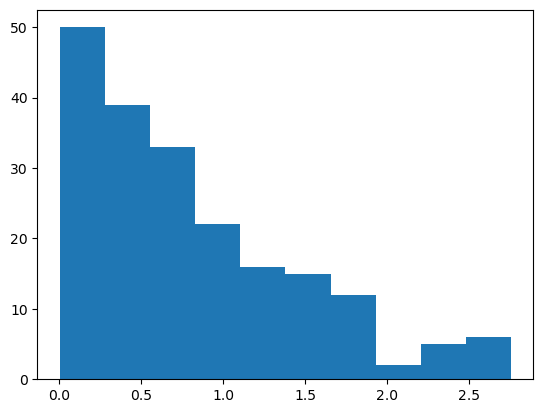

In [3]:
#標準偏差:1の半正規分布をサンプリング
temp1 = pm.HalfNormal.dist(sigma=1,shape=(200,))
a1_true = pm.draw(temp1)

plt.hist(a1_true)

In [4]:
a1_true.shape

(200,)

(array([ 2.,  5., 15., 32., 54., 38., 33., 13.,  6.,  2.]),
 array([-2.75128792, -2.20214012, -1.65299232, -1.10384452, -0.55469672,
        -0.00554892,  0.54359887,  1.09274667,  1.64189447,  2.19104227,
         2.74019007]),
 <BarContainer object of 10 artists>)

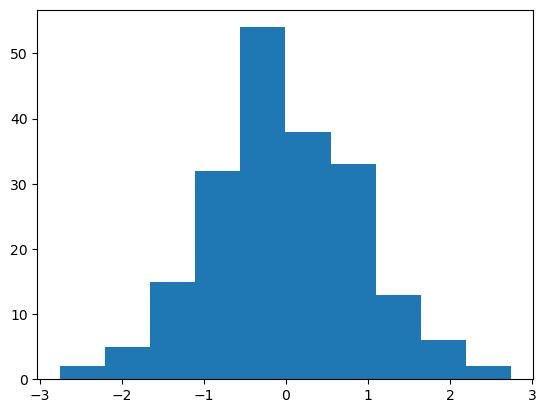

In [5]:
#標準偏差:1の正規分布をサンプリング
temp2 = pm.Normal.dist(sigma=1,shape=(200,))
a2_true = pm.draw(temp2)

plt.hist(a2_true)

In [6]:
pd.DataFrame({'a1_true':a1_true,'a2_true':a2_true})

,a1_true,a2_true
0,0.494073,-0.523067
1,2.506421,-0.679343
2,0.042621,0.122020
3,1.737719,-0.904762
4,0.766101,-0.048464
...,...,...
195,1.703111,0.391602
196,1.099040,0.237082
197,1.054762,0.579163
198,1.617143,2.740190


## 考え方  
a1_trueは半正規分布からサンプルした200の値　a2_trueは正規分布からサンプルした200の値  
↑が推定したい事前分布  
次に2×200行の一様分布からサンプルした特徴量を生成する(いわゆる観測できる値)

In [7]:
# 下限0,上限1の一様分布から200個サンプル
temp3 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
temp4 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
x1 = pm.draw(temp3)
x2 = pm.draw(temp4)

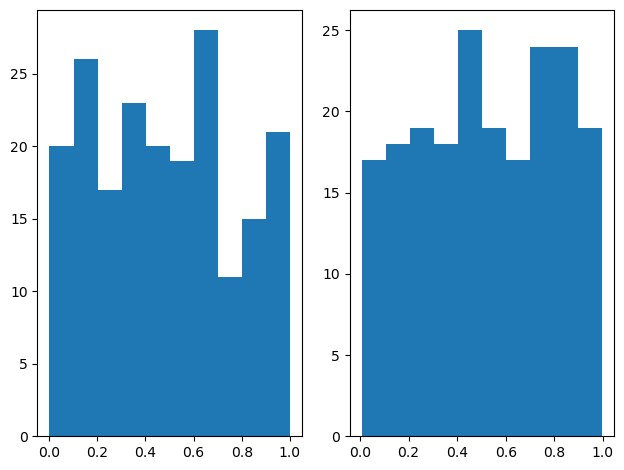

In [8]:
# 作成したx1,x2を可視化
fig ,ax = plt.subplots(1,2)
ax[0].hist(x1)
ax[1].hist(x2)
fig.tight_layout()

In [9]:
# 真の値を利用した目的変数を作成　変数複数
y = x1 *a1_true + x2 *a2_true

In [10]:
y

array([ 0.09055268,  0.43191515,  0.09364918,  0.26713934,  0.39269821,
       -0.49312844,  1.85709495,  0.2263196 ,  1.14031909,  0.34761442,
       -1.47867496, -1.18842562, -1.14167753, -0.44568953,  1.15464075,
        0.96958063,  1.15867754,  0.14235057,  1.0350809 ,  0.33735955,
        1.02099154,  1.20039001,  0.67990403,  0.09301505,  0.33356726,
        0.05331777,  0.26504821,  1.1535874 ,  2.18355629,  0.19604376,
       -0.05299163,  0.90772329,  0.44216979, -0.5212199 ,  0.72425773,
        1.33792566, -0.05902802,  1.61996421, -0.04616899,  0.56350414,
        2.15456843,  0.17405149,  0.57422821, -0.4541708 ,  0.19524814,
       -0.03156989,  1.38802447,  0.34484792,  0.4600119 , -0.31681631,
        1.00823644,  0.13944616,  0.08583891,  0.52702711,  1.28731877,
       -0.04147749,  1.35405722,  0.10499491, -0.12202432,  1.82517755,
        0.16249476,  0.19052171, -0.35608972,  1.19620273,  0.5366214 ,
       -0.34652517,  0.0808242 ,  0.36399639,  0.11324871,  0.44

(array([ 1.,  0.,  5.,  8., 31., 74., 33., 36.,  8.,  4.]),
 array([-2.47426975, -1.99173414, -1.50919853, -1.02666293, -0.54412732,
        -0.06159171,  0.42094389,  0.9034795 ,  1.3860151 ,  1.86855071,
         2.35108632]),
 <BarContainer object of 10 artists>)

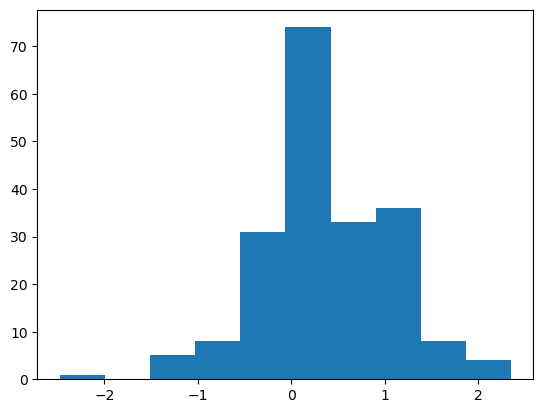

In [11]:
plt.hist(y)

In [12]:
df1 = pd.DataFrame({'x1':x1,'x2':x2, 'y':y})

In [16]:
# 観測できているデータを確認
df1

,x1,x2,y
0,0.621718,0.287146,1.006476
1,0.265665,0.415479,0.064130
2,0.187457,0.226150,0.447104
3,0.540566,0.243684,0.582088
4,0.271808,0.329046,0.059374
...,...,...,...
195,0.639122,0.229651,0.441624
196,0.022366,0.124694,-0.190803
197,0.056259,0.635804,0.170516
198,0.772826,0.706893,2.087819


## モデルを作成  
x1には半正規分布の事前分布を設定  
x２には正規分布の事前分布を設定  
y(尤度)は正規分布

In [13]:
df_x1=df1['x1']
df_x2=df1['x2']
df_y =df1['y']

In [14]:
model1 = pm.Model()

In [15]:
with model1:
    #観測データを定義
    model1.add_coord('data',df_x1.index, mutable=True)
    model1.add_coord('var',df1.columns, mutable=True)
    x1_data= pm.Data("x1_data", df_x1, dims=('data'), mutable=True)
    x2_data= pm.Data("x2_data", df_x2, dims=('data'), mutable=True)
    y_data = pm.Data("y_data", df_y, dims=('data'), mutable=True)

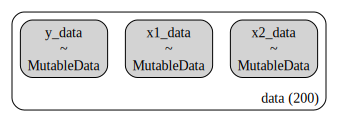

In [19]:
pm.model_to_graphviz(model1)

In [21]:
with model1:
    #事前分布を定義
    
    #切片を標準偏差100の正規分布で定義
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    #x1の傾きを半正規分布で定義
    a1 = pm.HalfNormal("a1", sigma=100)
    #x2の傾きを正規分布で定義
    a2= pm.Normal("a2",mu=0, sigma=100)
    
    #誤差を半正規分布で定義
    epsilon = pm.HalfNormal("epsilon", sigma=100)

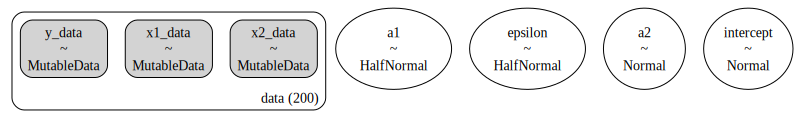

In [22]:
pm.model_to_graphviz(model1)

In [23]:
with model1:
    #観測データ(正規分布を仮定)の平均を計算　重回帰の計算結果が平均となる
    mu = pm.Deterministic("mu", intercept + pt.dot(x1_data, a1) + pt.dot(x2_data,a2), dims=('data',))
    
    #観測データ(尤度)(正規分布を仮定)を定義
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y_data, dims=('data',)) 

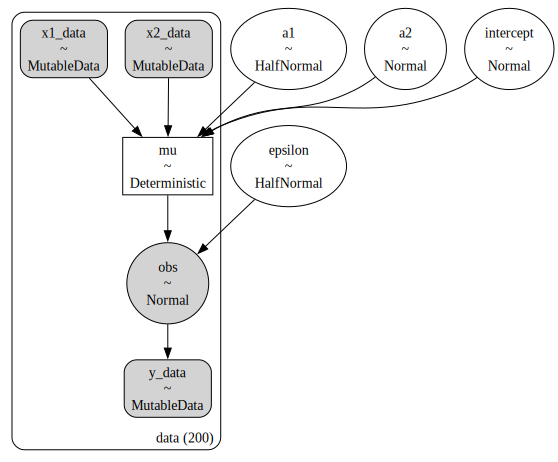

In [24]:
pm.model_to_graphviz(model1)

In [35]:
# MCMC実行 通常のサンプル
with model1:
    idata1 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, a1, a2, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 179 seconds.


In [36]:
summary1 = az.summary(idata1,var_names=['a1','a2','epsilon'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.760,0.167,0.457,1.084,0.004,0.003,1950.0,1916.0,1.0
a2,-0.307,0.169,-0.617,0.028,0.004,0.003,1879.0,2054.0,1.0
epsilon,0.682,0.035,0.620,0.748,0.001,0.000,3047.0,2648.0,1.0


In [37]:
# MCMC実行　サンプラー:blackjax
with model1:
    idata2 = pm.sample(nuts_sampler="blackjax",random_seed=42)

Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:00.642338
Sampling...
Sampling time = 0:00:03.577832
Transforming variables...
Transformation time = 0:00:00.090042


In [38]:
#R_hat 1.0のため収束出来てそう
summary2 = az.summary(idata2,var_names=['a1','a2','epsilon'])
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.768,0.167,0.466,1.096,0.003,0.002,2345.0,1996.0,1.0
a2,-0.303,0.167,-0.624,-0.006,0.004,0.002,2236.0,2007.0,1.0
epsilon,0.681,0.035,0.618,0.749,0.001,0.000,3226.0,2202.0,1.0


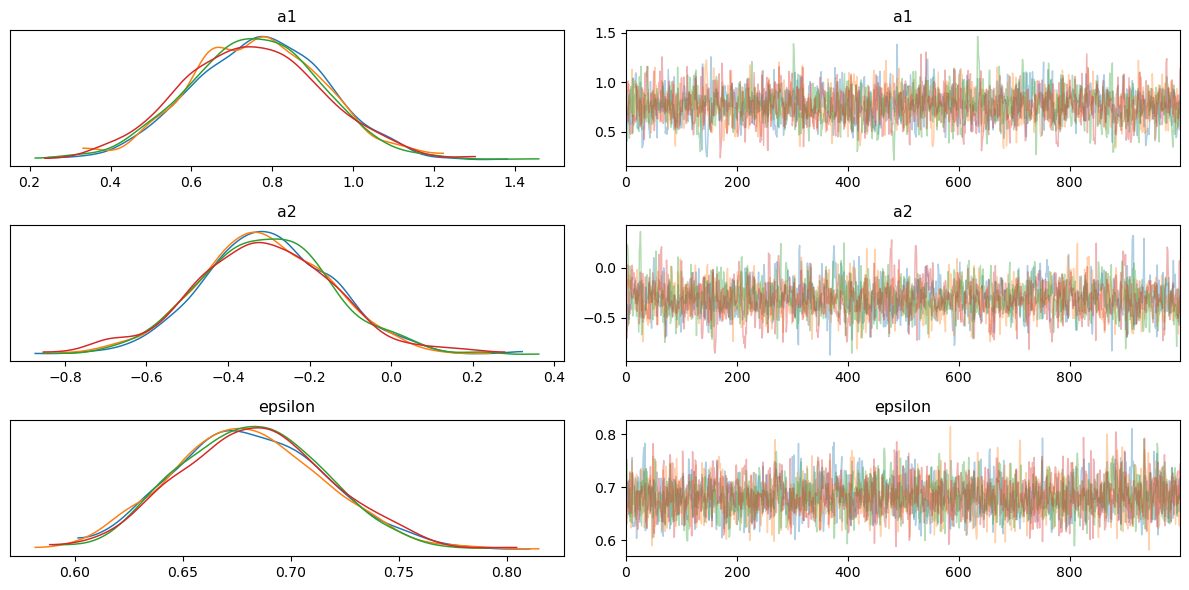

In [39]:
#通常のサンプラーのトレース結果
az.plot_trace(idata1, compact=False, var_names=['a1','a2','epsilon'])
plt.tight_layout()

array([<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

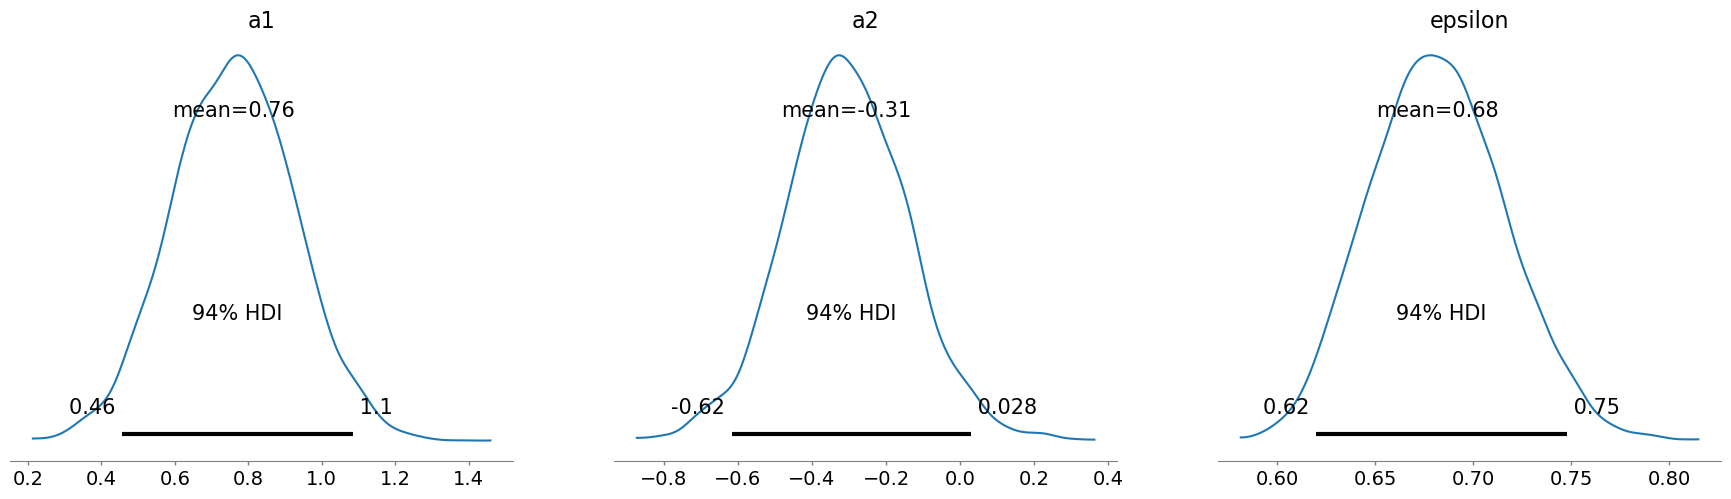

In [40]:
#通常のサンプラーのトレース結果
az.plot_posterior(idata1, var_names=['a1','a2','epsilon'])

array([<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

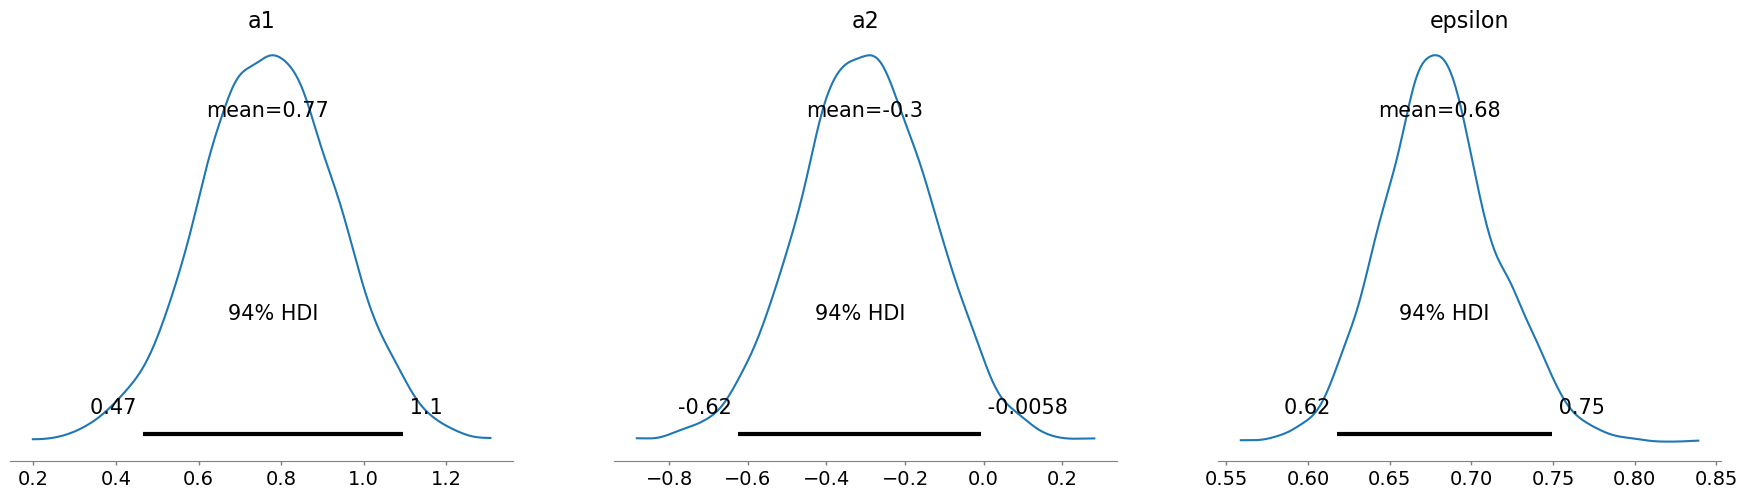

In [41]:
#サンプラー:blackjaxのトレース結果
az.plot_posterior(idata2, var_names=['a1','a2','epsilon'])

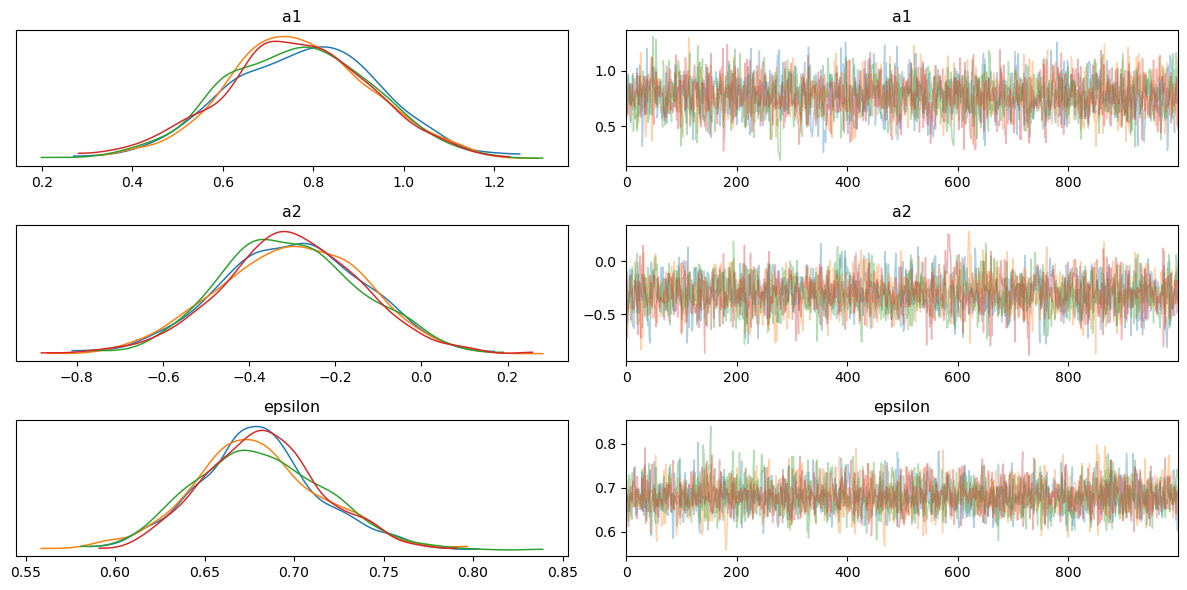

In [42]:
#サンプラー:blackjaxのトレース結果
az.plot_trace(idata2, compact=False, var_names=['a1','a2','epsilon'])
plt.tight_layout()

## MCMCの結果考察  
R_hatが1.0、グラフも定常状態になっているため収束出来ていると判断

## 真の値とMCMCの結果の比較

In [29]:
a1_true.mean()

0.8117030921787008

In [47]:
#通常のサンプラーのa1の平均値
idata1['posterior']['a1'].values.mean()

0.7598657534749748

In [46]:
#サンプラー:blackjaxのa1の平均値
idata2['posterior']['a1'].values.mean()

0.7680374438667175

In [31]:
a2_true.mean()

-0.030333585314880906

In [48]:
#通常のサンプラーのa2の平均値
idata1['posterior']['a2'].values.mean()

-0.30705319446751905

In [49]:
#サンプラー:blackjaxのa2の平均値
idata2['posterior']['a2'].values.mean()

-0.302574043911136

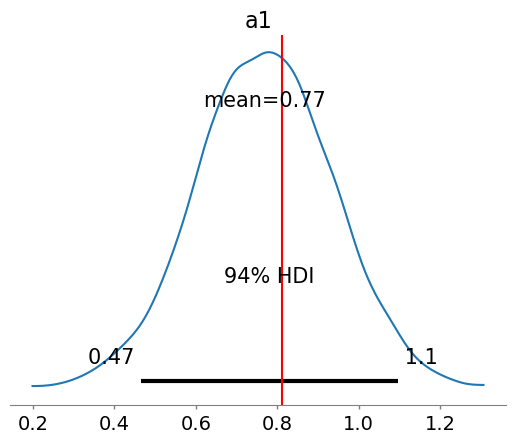

In [33]:
## 通常のサンプラーの結果確認
az.plot_posterior(idata1, var_names=['a1'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a1_true.mean(),color='red')

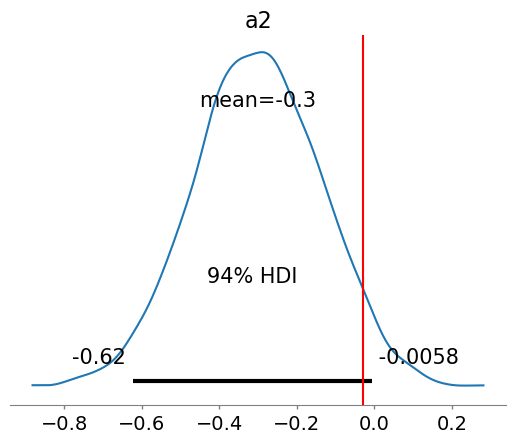

In [34]:
## 通常のサンプラーの結果確認
az.plot_posterior(idata1, var_names=['a2'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a2_true.mean(),color='red')

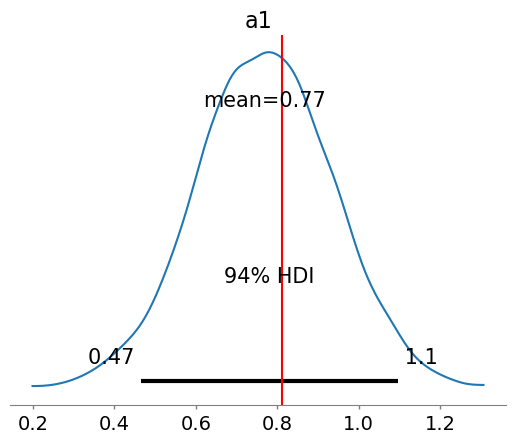

In [50]:
#サンプラー:blackjaxの結果確認
az.plot_posterior(idata2, var_names=['a1'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a1_true.mean(),color='red')

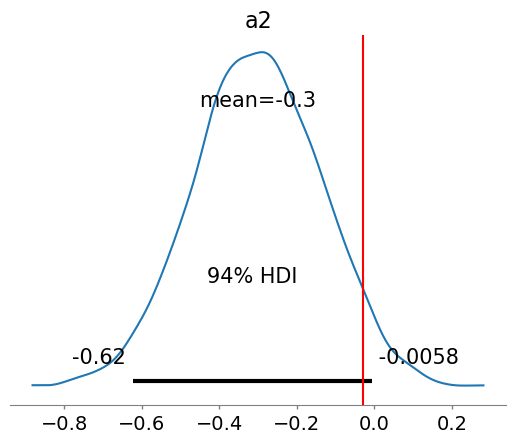

In [51]:
#サンプラー:blackjaxの結果確認
az.plot_posterior(idata2, var_names=['a2'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a2_true.mean(),color='red')